# Plant Seedling Classification using Convolutional Neural Networks
This dataset consists of a training set and a testing set of images of plant seedlings at various growth stages. Each image has its own unique ID. The dataset has 12 main plant species which we need to classify the testing set into. 
For this task we will need to process and clean the data using image processing Then we will have to build a model and evaluate it.
Let's get started! 

**(1). Importing all the necessary modules:**

In [1]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# GLOBAL VARIABLES
scale = 70
seed = 7

Using TensorFlow backend.


**(2). Getting the data and resizing the images:**

In [2]:
import os
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

data_dir = '../input/plant-seedlings-classification'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        if file != '.DS_Store':
            train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(5)

,file,category_id,category
0,train/Black-grass/d3c72d4c3.png,0,Black-grass
1,train/Black-grass/37d85d833.png,0,Black-grass
2,train/Black-grass/b024eeb75.png,0,Black-grass
3,train/Black-grass/22be204a3.png,0,Black-grass
4,train/Black-grass/0260cffa8.png,0,Black-grass


In [4]:
trainingset = []

for i in range(train.shape[0]):
    trainingset.append(cv2.resize(cv2.imread(data_dir +'/'+ train['file'][i]),(scale,scale)))

trainingset = np.asarray(trainingset)

In [5]:
for i in range(5):
    print(trainingset)

[[[[156 154 149]
   [172 168 159]
   [181 174 164]
   ...
   [190 180 175]
   [189 179 175]
   [188 179 176]]

  [[129 131 133]
   [156 153 148]
   [171 166 157]
   ...
   [189 179 175]
   [188 178 175]
   [189 180 178]]

  [[ 98 105 116]
   [126 128 130]
   [150 149 144]
   ...
   [188 178 175]
   [189 179 177]
   [188 180 179]]

  ...

  [[100 123 145]
   [100 122 143]
   [106 126 146]
   ...
   [ 43  55  73]
   [ 44  56  75]
   [ 44  56  76]]

  [[103 126 146]
   [105 126 145]
   [107 126 145]
   ...
   [ 43  55  72]
   [ 47  60  78]
   [ 47  59  78]]

  [[103 126 145]
   [103 124 144]
   [105 124 143]
   ...
   [ 43  56  72]
   [ 50  63  80]
   [ 48  60  79]]]


 [[[ 51  65  81]
   [ 70  79  90]
   [ 61  69  81]
   ...
   [ 48  61  83]
   [ 58  73  92]
   [ 58  75  97]]

  [[ 37  53  72]
   [ 49  61  73]
   [ 58  70  81]
   ...
   [ 50  65  87]
   [ 54  73  97]
   [ 56  74  96]]

  [[ 36  50  72]
   [ 37  45  61]
   [ 38  45  66]
   ...
   [ 53  68  92]
   [ 54  75  96]
   [ 55  75

**(3). Cleaning the images and removing the background:**
* Cleaning of the images is an intensive task. We will have to:
    * Convert the RGB image into HSV.
    * We will have to blur the image to remove noise.
    * We will have to create a mask to remove the background.

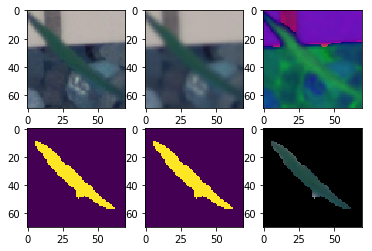

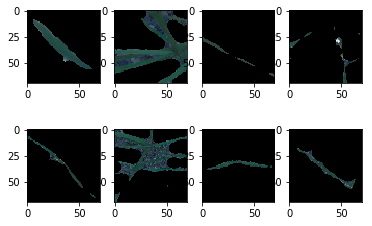

In [6]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

**(4). Converting the Labels into numbers:**
* The labels are strings and these are hard to process. So we'll convert these labels into a binary classification.
* The classification can be represented by an array of 12 numbers which will follow the condition:
    * 0 if the species is not detected.
    * 1 if the species is detected.
* Example: If Blackgrass is detected, the array will be = [1,0,0,0,0,0,0,0,0,0,0,0]

In [7]:
# convert category_id to binary label
id = np.array(train['category_id'])
trainL = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
for i in range(train.shape[0]):
    zero = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    zero[id[i]]=1
    trainL = np.vstack((trainL,zero))
clearalllabels = np.delete(trainL,(0), axis=0)

**(5). Defining our model and splitting the dataset:**
* We need to split the training set for validation.

In [8]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

**(6). Preventing Overfitting:**
* To prevent overfitting, we need to create a function that can randomly change image characterisitics during fitting.

In [9]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [ ]:
from keras import regularizers, applications, optimizers, initializers
from keras.models import Sequential, Model
base_model = applications.vgg16.VGG16(weights='imagenet',
                                               include_top=False,
                                               input_shape=x_train.shape[1:])

for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True
    
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(12, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**(7). Defining the Convolutional Neural Network:**
* This model has 4 convolution layers.
* This model has 3 fully connected layers.

In [10]:
classes=12
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       204928    
__________

**(8). Fitting the CNN onto the data:**
* We have to set a few callbacks:
    * We have to reduce the learning rate because, convergence will be much quicker.
    * We have to save the best weights of the model.
    * We have to save the last weights of the model.    

In [11]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [12]:
# SETTING UP CHECKPOINTS, CALLBACKS AND REDUCING LEARNING RATE
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

filepath="./best-model.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoints, lrr, checkpoints]


hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=75), 
                           epochs=10, validation_data=(x_test, y_test), 
                           steps_per_epoch=x_train.shape[0], callbacks=callbacks_list)

Epoch 1/10
4275/4275 [==============================] - 762s 178ms/step - loss: 0.6729 - acc: 0.7712 - val_loss: 14.0482 - val_acc: 0.1284

Epoch 00001: val_acc improved from -inf to 0.12842, saving model to ./best-model.hdf5

Epoch 00001: val_acc did not improve from 0.12842
Epoch 2/10
4275/4275 [==============================] - 755s 177ms/step - loss: 0.2474 - acc: 0.9093 - val_loss: 14.0482 - val_acc: 0.1284

Epoch 00002: val_acc did not improve from 0.12842

Epoch 00002: val_acc did not improve from 0.12842
Epoch 3/10
4275/4275 [==============================] - 755s 177ms/step - loss: 0.1878 - acc: 0.9289 - val_loss: 14.3537 - val_acc: 0.1095

Epoch 00003: val_acc did not improve from 0.12842

Epoch 00003: val_acc did not improve from 0.12842
Epoch 4/10
4275/4275 [==============================] - 755s 177ms/step - loss: 0.1512 - acc: 0.9417 - val_loss: 14.8659 - val_acc: 0.0758

Epoch 00004: val_acc did not improve from 0.12842

Epoch 00004: ReduceLROnPlateau reducing learning r

**(9). Confusion Matrix:**
* The confusion matrix is one of the best ways to analyse the errors in the model.
* It gives the exact number of correct and incorrect predictions

In [13]:
# PREDICTIONS
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[ 0  0  0 15  1  0  0  9  0  0  0  1]
 [ 0  0  0 31  0  8  0  0  0  0  0  0]
 [ 0  0  0 21  0  8  0  0  0  0  0  0]
 [ 0  0  0 31  0 25  0  5  0  0  0  0]
 [ 0  0  0 10  1  2  0  6  0  0  0  3]
 [ 0  0  0 43  0  4  0  0  0  0  0  0]
 [ 0  0  0 35  0  1  0 26  0  0  0  3]
 [ 0  0  0 14  0  8  0  0  0  0  0  0]
 [ 0  0  0 39  0 13  0  0  0  0  0  0]
 [ 0  0  0 19  0  4  0  0  0  0  0  0]
 [ 0  0  0 17  0 21  0 12  0  0  0  0]
 [ 0  0  0 14  0 13  0 12  0  0  0  0]]


 **(10). Process the testing set and getting predictions:**

In [14]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)

,filepath,file
0,test/0e8492cb1.png,0e8492cb1.png
1,test/b687160f5.png,b687160f5.png


In [15]:
testimages = []

for i in range(test.shape[0]):
    testimages.append(cv2.resize(cv2.imread(test_dir +'/'+ test['file'][i]),(scale,scale)))

testimages = np.asarray(testimages)

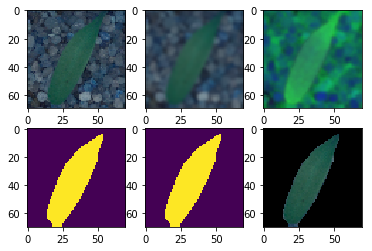

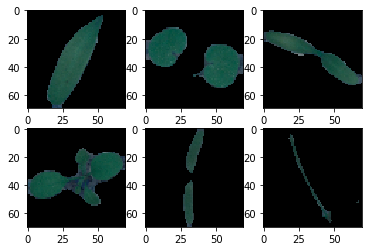

In [16]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
# OTHER MASKED IMAGES
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [17]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)

# PREDICTION TO A CSV FILE
pred = np.argmax(prediction,axis=1)
predStr = []
for i in range(len(pred)):
    predStr.append(CATEGORIES[pred[i]])
preddf = pd.DataFrame({'species':predStr})

result=pd.concat([test[['file']], preddf], axis=1)
result.head(5)

result.to_csv("Prediction.csv",index=False)

,file,species
0,0e8492cb1.png,Common Chickweed
1,b687160f5.png,Maize
2,fea3da57c.png,Common Chickweed
3,f6d250856.png,Common Chickweed
4,e73e308be.png,Common Chickweed
